# Faulty Stations Identified

In [38]:
faulty_stations_mb_4 = ['D3FE8EEF188C', 'D883D89E6A24', 'EC032D8260EB', 'F5C16A4B6340']
faulty_stations_mb_5 = ['C059A2225266', 'D63DFE9B164B', 'D07769DF208C', 'DF15D23E4B15', 'E2A0DF1A4941', 'E437CB2AF225', 'F5C16A4B6340', 'F033A8C6BB79', 'F4683D808CFB']
faulty_stations_mb_6 = ['C059A2225266', 'C3FD36A6C1BC', 'D07769DF208C', 'D083B9FD07FB', 'DF15D23E4B15', 'E2A0DF1A4941', 'EB90524D4F3E', 'F4683D808CFB', 'F5C16A4B6340', 'FCBBD3B1DB2C']
faulty_stations_mb_7 = []
faulty_stations_mb_8 = []

all_faulty = (faulty_stations_mb_4 + faulty_stations_mb_5 + faulty_stations_mb_6 + faulty_stations_mb_7 + faulty_stations_mb_8)

# EXPLORATORY DATA ANALYSIS 
To identify problematic stations for a specific time window, usually set by a PALM simulation file. 

In [20]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from feature_generation import in_window

datapath: str = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/Data/Messdaten/Daten_Meteoblue'
info: pd.DataFrame = pd.read_csv('S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/Data/Messdaten/stations_new.csv', delimiter=';')
info = info.set_index('stationid_new')

time_id: str = 'mb_6'
start: pd.DatetimeIndex = pd.to_datetime('2019-08-13 18:00')
end: pd.DatetimeIndex = pd.to_datetime('2019-08-15 02:00')

In [23]:
%matplotlib inline

Go through each station and visually inspect its plausibility. Stations with faulty measurements and strange behaviour are documented in ``QRF_Experiments_Documentation_FINAL.docx``

In [22]:
def temp_tsplots(temps, station_id, start, end, savepath):
    plt.ioff()
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax = sns.scatterplot(x=temps['datetime'], y=temps['temp'], ax=ax)
    ax.set_title(f'Temperature at station {station_id} from {start} to {end}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature [°C]')
    plt.xticks(rotation=45)  
    fig.savefig(savepath, dpi=300)  
    plt.close(fig)

In [24]:
savepath: str = os.path.join(os.path.dirname(datapath), 'Exploratory Analysis', time_id)
if not os.path.exists(savepath):
    os.makedirs(savepath)

timeseriespath: str = os.path.join(savepath, 'Timeseries')
if not os.path.exists(timeseriespath):
    os.makedirs(timeseriespath)

In [34]:
%matplotlib inline

temps = {'station': [], 'temp': [], 'datetime': []}

for file in os.listdir(datapath):
    if file.startswith('temp'):
        stationid: str = os.path.splitext(file)[0].split('_')[1]
        imgpath = os.path.join(timeseriespath, f'{stationid}.jpg')
        temp_df: pd.DataFrame = pd.read_csv(os.path.join(datapath, file), delimiter=';', parse_dates=True)
        temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
        idxs: list[bool] = in_window([start, end], temp_df['datetime'])
        if not np.sum(idxs):
            continue
        temp_df = temp_df.loc[idxs]
        if not os.path.exists(imgpath):
            temp_tsplots(temp_df, stationid, start, end, imgpath)
        
        temps['temp'].extend(temp_df['temp'].values)
        temps['datetime'].extend(temp_df['datetime'].values)
        temps['station'].extend([stationid] * len(temp_df))

C:\Users\ushe\AppData\Local\Temp\ipykernel_17724\2137207821.py:10: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])


Plot of all station time series before visual analysis 

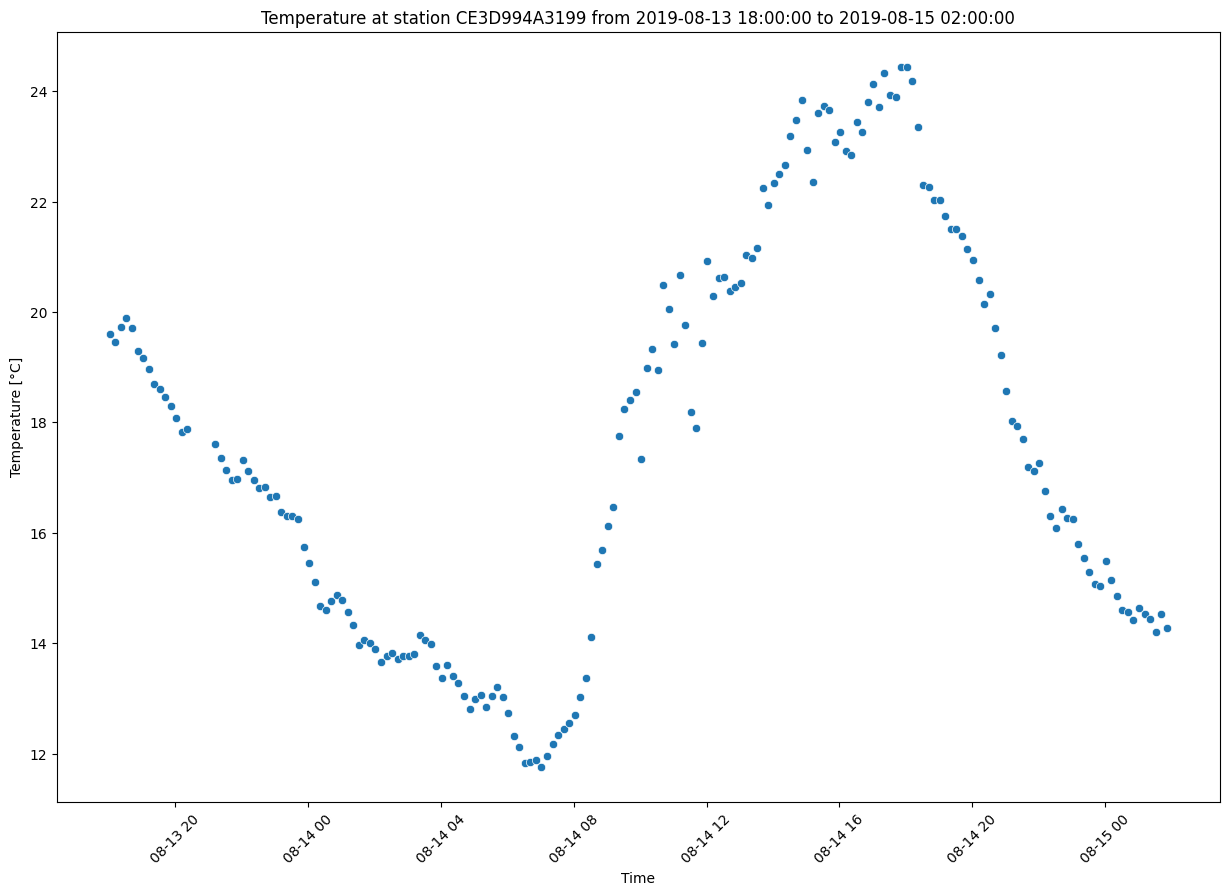

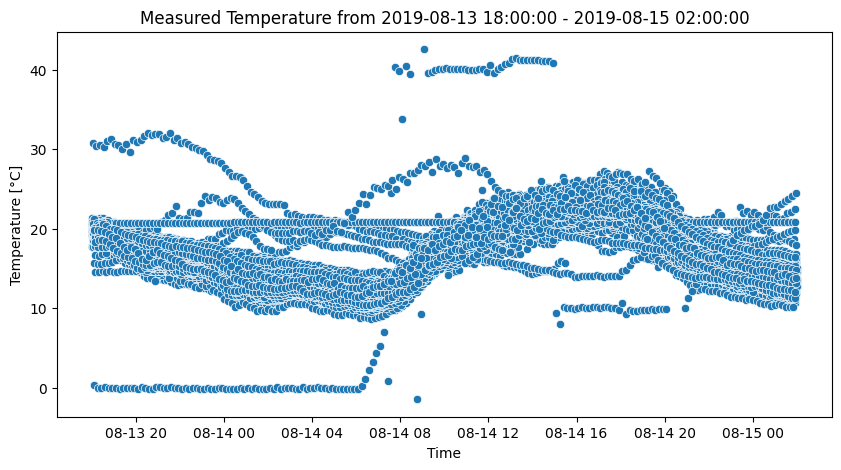

In [35]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.scatterplot(x=temps['datetime'], y=temps['temp'])
ax.set_title(f'Measured Temperature from {start} - {end}')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
ax._remove_legend(ax.get_legend())

Generated time series images are classified into one of three categories:
1. time series is plausible (``Plausible``)
2. sensor is faulty (``faulty``)
3. midday correction / smoothing needed (``overheated``)
4. time series with no data (``Empty``)

In [36]:
%matplotlib qt

import data_correction
from pathlib import Path
from importlib import reload
reload(data_correction)

savepaths = {'Plausible': os.path.join(savepath, 'Plausible'), 
             'Faulty': os.path.join(savepath, 'Faulty'), 
             'Overheated': os.path.join(savepath, 'Correct')}

labeller = data_correction.LabellingTool(savepaths, Path(timeseriespath))
labeller.run_labelling()

No more images to label.
Labels saved to labels.csv


Show plausible, faulty and overheated stations

In [39]:
labels = pd.read_csv(os.path.join(savepath, 'labels.csv'), delimiter=',')
stations_plausible = labels.loc[labels['label'] == 'Plausible']['station_id'].unique()
stations_overheated = labels.loc[labels['label'] == 'Overheated']['station_id'].unique()
stations_faulty = labels.loc[labels['label'] == 'Faulty']['station_id'].unique()
temps['label'] = ['Plausible' if station in stations_plausible else 'Overheated' if station in stations_overheated else 'Faulty' if station in stations_faulty else 'Empty' for station in temps['station']]

Text(0, 0.5, 'Temperature [°C]')

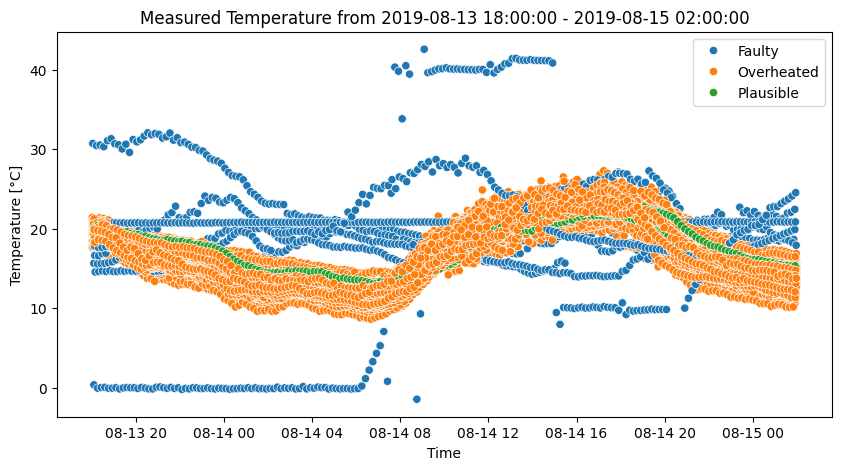

In [41]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.scatterplot(x=temps['datetime'], y=temps['temp'], hue=temps['label'])
ax.set_title(f'Measured Temperature from {start} - {end}')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')

Text(0, 0.5, 'Temperature [°C]')

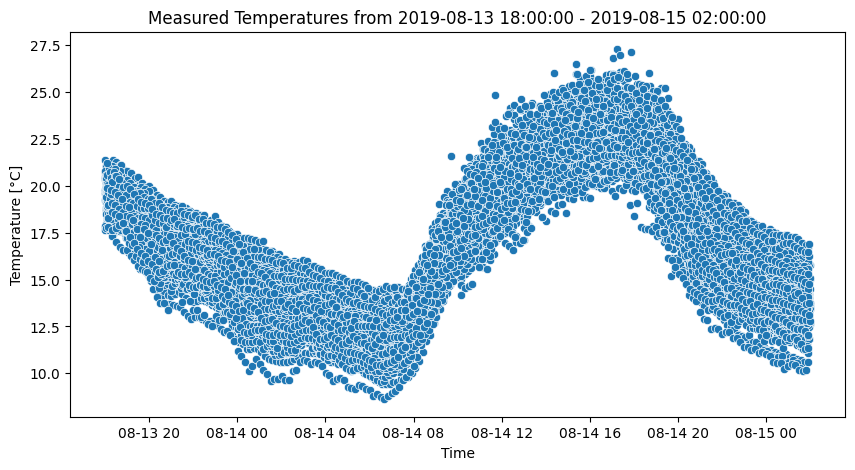

In [42]:
temps = pd.DataFrame(temps)
temps_cleaned = temps.drop(index=np.where(np.array(temps['label']) == 'Faulty')[0])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.scatterplot(x=temps_cleaned['datetime'], y=temps_cleaned['temp'])
ax.set_title(f'Measured Temperatures from {start} - {end}')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')

Text(0, 0.5, 'Temperature [°C]')

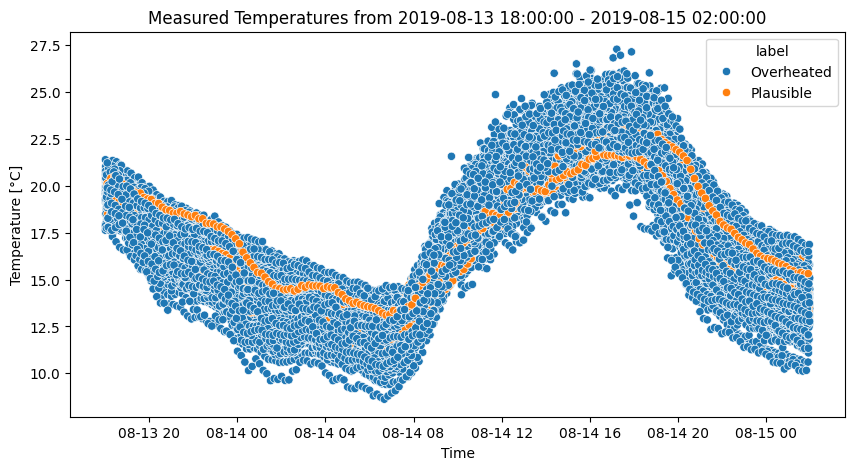

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.scatterplot(x=temps_cleaned['datetime'], y=temps_cleaned['temp'], hue=temps_cleaned['label'])
ax.set_title(f'Measured Temperatures from {start} - {end}')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')

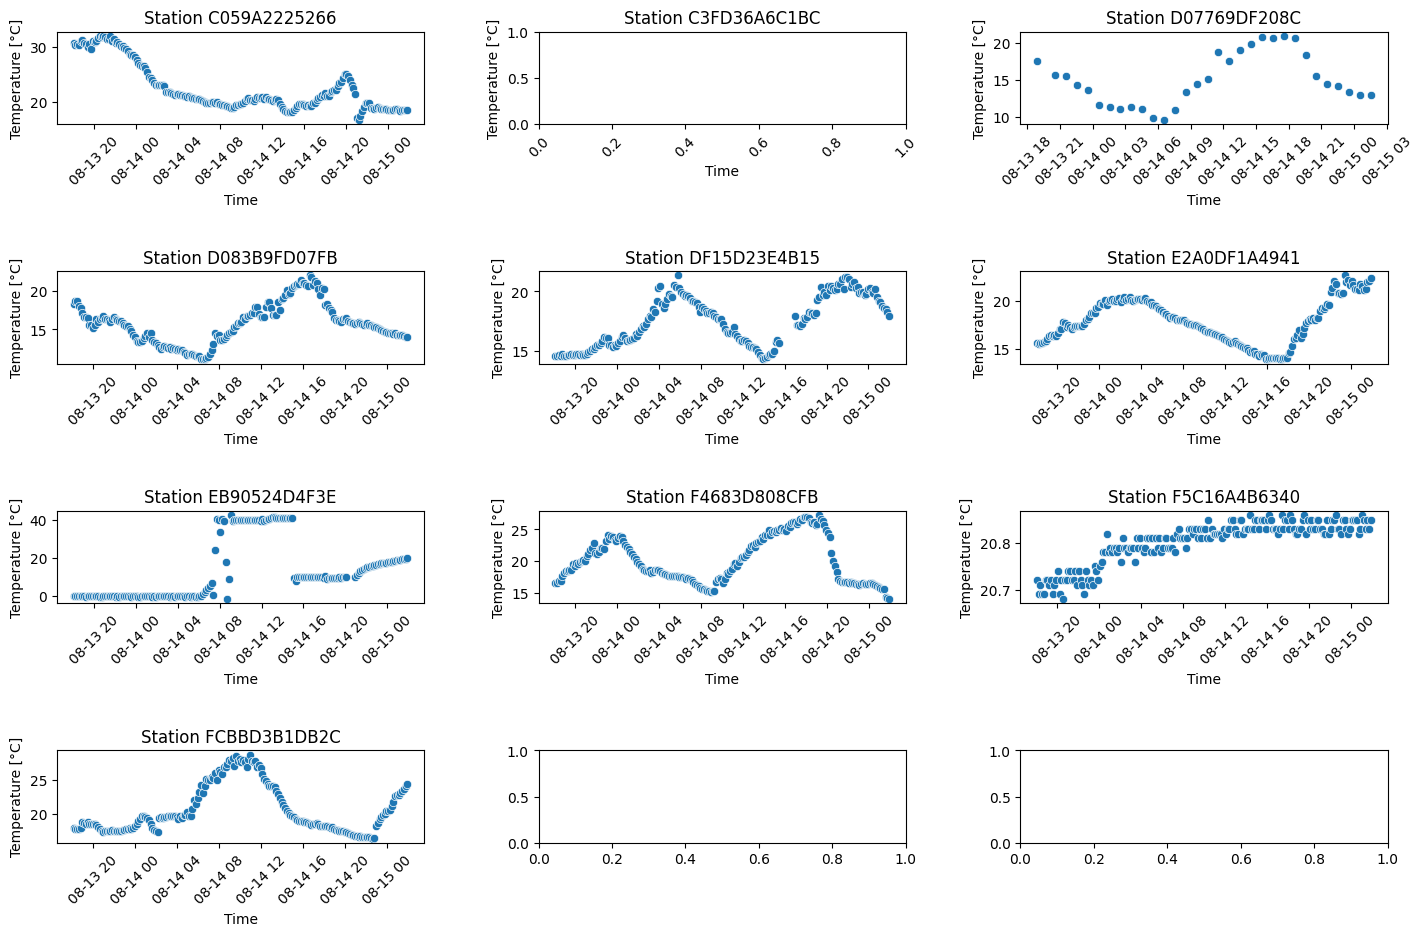

In [44]:
nfaulty = len(stations_faulty)
cols = 3
rows = int(np.ceil(nfaulty / cols))
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
for i, station in enumerate(stations_faulty):
    ax = axes[i // cols, i % cols]
    temp_df = temps.loc[temps['station'] == station]
    ax = sns.scatterplot(x=temp_df['datetime'], y=temp_df['temp'], ax=ax)
    ax.set_title(f'Station {station}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Temperature [°C]')
    for label in ax.get_xticklabels():
        label.set_rotation(45)
fig.tight_layout(pad=3.0)

In [51]:
stationid = stations_faulty[0]
stationdata = pd.read_csv(os.path.join(datapath, f'temp_{stationid}.csv'), delimiter=';')
stationdata['datetime'] = pd.to_datetime(stationdata['datetime'])
stationdata['month'] = stationdata['datetime'].dt.month
nmonths = len(stationdata['month'].unique())
nmonths

6

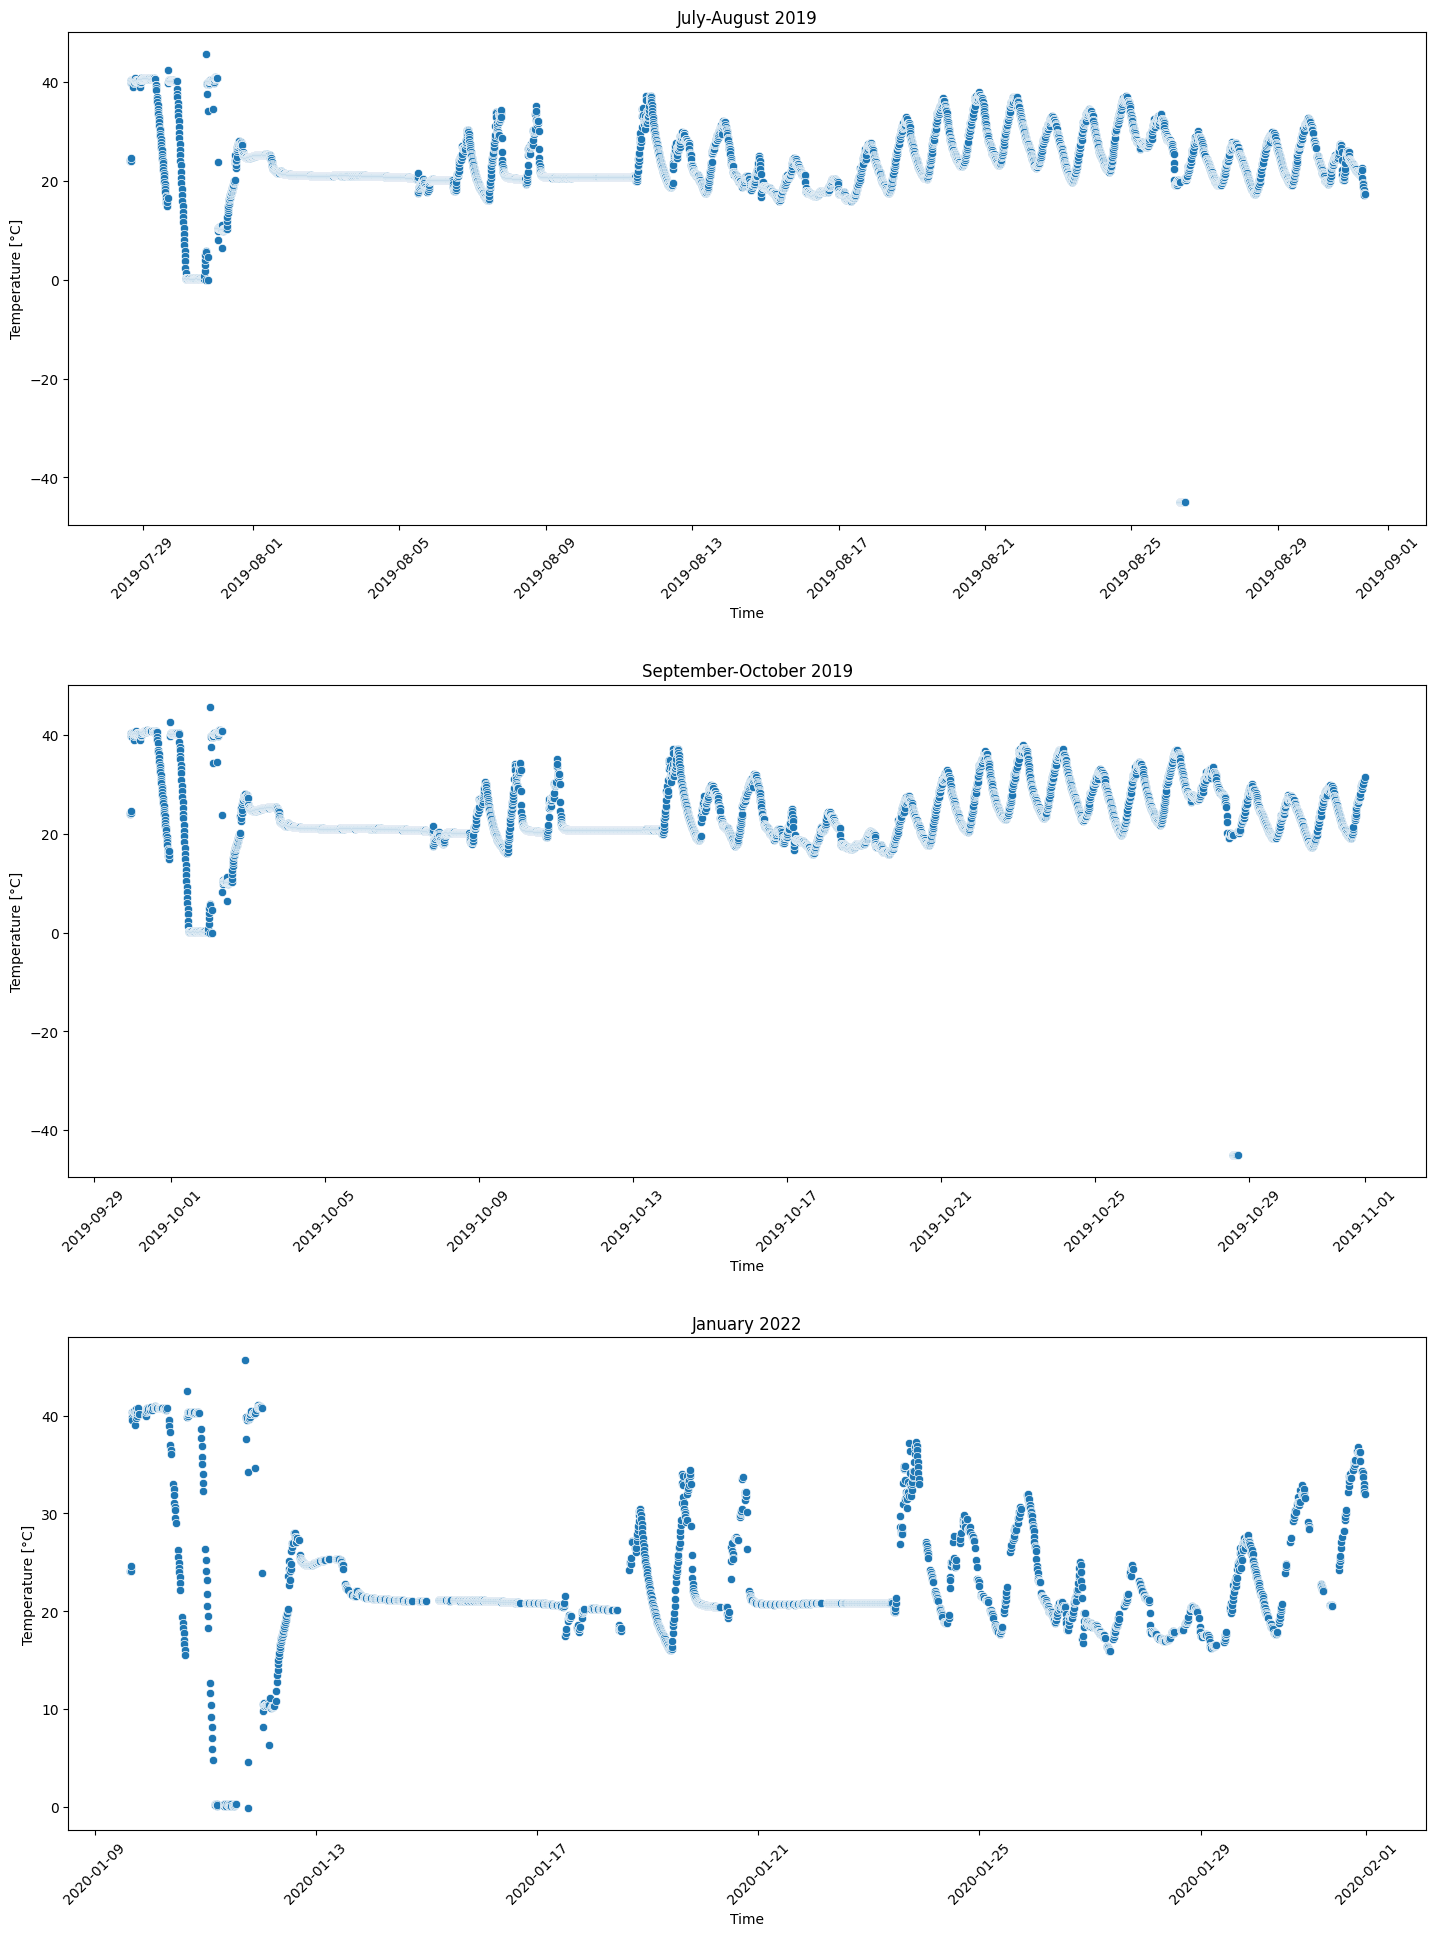

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))
idxs = [month in [7, 8] for month in stationdata['month']]
temp_df = stationdata.loc[idxs]
ax = sns.scatterplot(x=temp_df['datetime'], y=temp_df['temp'], ax=axes[0])
ax.set_title(f'July-August 2019')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
for label in ax.get_xticklabels():
    label.set_rotation(45)

idxs = [month in [9, 10] for month in stationdata['month']]
temp_df = stationdata.loc[idxs]
ax = sns.scatterplot(x=temp_df['datetime'], y=temp_df['temp'], ax=axes[1])
ax.set_title(f'September-October 2019')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
for label in ax.get_xticklabels():
    label.set_rotation(45)

temp_df = stationdata.loc[stationdata['month'] == 1]
ax = sns.scatterplot(x=temp_df['datetime'], y=temp_df['temp'], ax=axes[2])
ax.set_title(f'January 2022')
ax.set_xlabel('Time')
ax.set_ylabel('Temperature [°C]')
for label in ax.get_xticklabels():
    label.set_rotation(45)

fig.tight_layout(pad=3.0)